## Imports

In [233]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm
from statsmodels.api import OLS

#SKLearn stuff
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,PolynomialFeatures,OrdinalEncoder,OneHotEncoder,power_transform
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

# Header cleaning. More precautionary than anything else
df.columns = [x.strip().lower().replace(' ','').replace('-','') for x in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [3]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Remove outliers

In [4]:
# Removing outliers
df = df[df['bedrooms'] <=10] #2 records remove. 33 BR home and 11 BR home
df = df[df['grade'] != '3 Poor'] #only 1 instance of this exists

In [5]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      195
7       38
8       13
9        6
10       3
Name: bedrooms, dtype: int64

## Data Cleaning

sqft_basement is an object?

In [6]:
df.sqft_basement.sort_values()

0        0.0
12644    0.0
12645    0.0
12646    0.0
12648    0.0
        ... 
20929      ?
20931      ?
20934      ?
5376       ?
10783      ?
Name: sqft_basement, Length: 21594, dtype: object

sqft_basement is a list of strings that include some unknowns marked as '?'

In [7]:
len(df[df.sqft_basement=='?']) /len(df)

0.02102435861813467

In [8]:
df_subset_basement = df[df.sqft_basement !='?'] #subset of  records where sqft_basement is not '?'
df_subset_basement.sqft_basement = df_subset_basement.sqft_basement.astype(float,)

In [9]:
#check to see how much of the current sqft_basement (excluding '?') can be explained by (sqft_living-sqft_above)

(df_subset_basement.sqft_living - df_subset_basement.sqft_above == df_subset_basement.sqft_basement).sum()/df_subset_basement.shape[0]

1.0

So, 98% of the sqft_basement data has a value in it which can be explained using this math. The remaining missing data is filled with '?'. Fill using this math

In [10]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [11]:
# # Change view rating to a numeric value. Probably don't need it
# df['view'] = df['view'].map({'EXCELLENT':5,
#                              'GOOD':4,
#                              'AVERAGE':3,
#                              'FAIR':2,
#                              'NONE':1})

# # Change condition rating to a numeric value. Probably don't need it
# df['condition'] = df['condition'].map({'Very Good':5,
#                                        'Good':4,
#                                        'Average':3,
#                                        'Fair':2,
#                                        'Poor':1})

# # Changing grade to just the numeric value of the grade
# df['grade'] = df['grade'].str.split(' ').str[0].astype(int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21594 non-null  int64  
 1   date           21594 non-null  object 
 2   price          21594 non-null  float64
 3   bedrooms       21594 non-null  int64  
 4   bathrooms      21594 non-null  float64
 5   sqft_living    21594 non-null  int64  
 6   sqft_lot       21594 non-null  int64  
 7   floors         21594 non-null  float64
 8   waterfront     19218 non-null  object 
 9   view           21531 non-null  object 
 10  condition      21594 non-null  object 
 11  grade          21594 non-null  object 
 12  sqft_above     21594 non-null  int64  
 13  sqft_basement  21594 non-null  int64  
 14  yr_built       21594 non-null  int64  
 15  yr_renovated   17752 non-null  float64
 16  zipcode        21594 non-null  int64  
 17  lat            21594 non-null  float64
 18  long  

In [13]:
#The number of records where view is nan is 0.29% of the dataset. Hence dropped
print(df.view.isna().sum() /df.shape[0])
df.dropna(subset=['view'],inplace=True)

0.002917477076965824


## Analyzing Corelations

In [14]:
df.corr().price.sort_values()

zipcode         -0.053664
id              -0.017412
long             0.022482
yr_built         0.054227
sqft_lot15       0.083193
sqft_lot         0.090340
yr_renovated     0.129983
floors           0.257053
lat              0.307824
bedrooms         0.315742
sqft_basement    0.321802
bathrooms        0.525065
sqft_living15    0.585323
sqft_above       0.605716
sqft_living      0.701614
price            1.000000
Name: price, dtype: float64

dropping yr_renovated . not enough records

dropping id, yr_built, floors, date, sqft_lot, sqft_lot15. Not enough correlation. Making predictions based on other columns

stakeholder: potential investor, homebuyer

keeping zipcode, lat, long for the purpose of potential visualizations

In [15]:
df = df.drop(columns = ['id','yr_renovated','yr_built','floors','date'],axis =1)

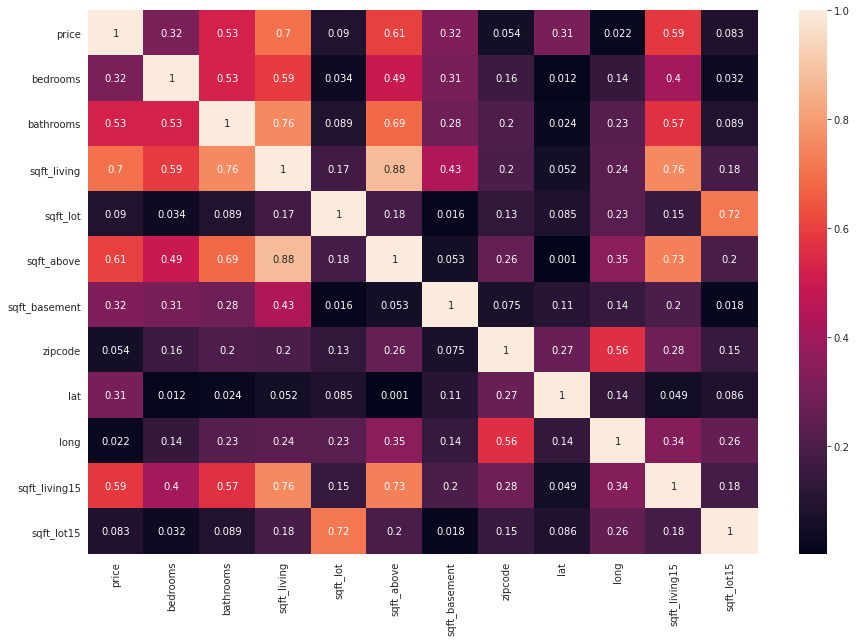

In [16]:
# sns.heatmap(df.corr(),annot=True)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(abs(df.corr()),annot=True)

Note the corelation between
- sqft_living and sqft_above (because sqft_living = sqft_above + sqft_basement). In fact a lot of the sqft are highly corelated
    - try feature engineering between them, or just pick 1 or 2
- grade to sqft_living15, sqft_above
- bathrooms to grade
- grade and sqft_living has highest impact on target (price)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21531 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21531 non-null  float64
 1   bedrooms       21531 non-null  int64  
 2   bathrooms      21531 non-null  float64
 3   sqft_living    21531 non-null  int64  
 4   sqft_lot       21531 non-null  int64  
 5   waterfront     19161 non-null  object 
 6   view           21531 non-null  object 
 7   condition      21531 non-null  object 
 8   grade          21531 non-null  object 
 9   sqft_above     21531 non-null  int64  
 10  sqft_basement  21531 non-null  int64  
 11  zipcode        21531 non-null  int64  
 12  lat            21531 non-null  float64
 13  long           21531 non-null  float64
 14  sqft_living15  21531 non-null  int64  
 15  sqft_lot15     21531 non-null  int64  
dtypes: float64(4), int64(8), object(4)
memory usage: 2.8+ MB


In [18]:
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
waterfront       2370
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [19]:
df.waterfront.isna().sum() / len(df)

0.11007384701128606

We'll have to keep an eye on the waterfront. Maybe drop the values? ~11% of data. Fill with 'NO'

In [20]:
df.waterfront = df.waterfront.fillna('NO')

In [21]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Helper Functions

In [185]:
def OHE_scale_lr(X_train,y_train,
                 X_test,y_test,
                 
                 num_col,
                 cat_col =[]
                ):
    """
    Creates a pipeline to perform a 
    - One-Hot-Encoding (OHE)
    - Standard Scaling
    - Linear Regression

    cat_col = list of categorical column names to process with OHE. default empty list
    num_col = list of numerical column names
    
    Keep transformations out of this function. Function applid post train-test split
    """
    if not (cat_col or num_col):
        print("no columns provided to perform operations")
        return None
    
    #List Comp to get subst of columns
    list_cols= [col for sublist_cols in [num_col,cat_col]for col in sublist_cols]
    print('Categorical columns:',cat_col,'\nNumerical Columns: ',num_col)
    
    #Create subsets of train and test sets
    X_train_subset = X_train[list_cols]
    X_test_subset = X_test[list_cols]
    
    
    if cat_col:
        X_train_subset,X_test_subset = OHEColXFER(cat_col,X_train_subset, X_test_subset)
    
    pipe = make_pipeline(RobustScaler(), LinearRegression())
    pipe.fit(X_train_subset, y_train) 
    print("Training Score:",pipe.score(X_train_subset, y_train))
    print("Test Score:",pipe.score(X_test_subset, y_test))
    
    train_preds= pipe.predict(X_train_subset)
    test_preds = pipe.predict(X_test_subset)
    
    get_train_test_metrics(y_train,train_preds,y_test,test_preds)
    
    
    
def OHEColXFER(cat_col,X_train_subset, X_test_subset):
    """
    In place column transformation using One Hot Encoding 
    """ 
    
    #Instantiate Encoder
    encoder = OneHotEncoder(handle_unknown='error',
                            drop='first',
                            categories='auto')
    
    #Instantiate Column Transformer
    ct = ColumnTransformer(transformers=[('ohe', encoder, cat_col)],
                           remainder='passthrough')

    #Fit Column Transformer
    ct.fit(X_train_subset)

    #Get your encoded Training and Test sets. Sometimes need to force todens(0) depending upon size of output
    try:
        X_train_enc = ct.transform(X_train_subset).todense()
    except:
        X_train_enc = ct.transform(X_train_subset)
    
    try:
        X_test_enc = ct.transform(X_test_subset).todense()
    except:
        X_test_enc = ct.transform(X_test_subset)
    
    # Get a nice dataframe
    X_train_enc = pd.DataFrame(X_train_enc, columns=ct.get_feature_names())
    X_test_enc = pd.DataFrame(X_test_enc, columns=ct.get_feature_names())
    
    return X_train_enc,X_test_enc
    
    
    
    
def get_train_test_metrics(y_train,train_preds,
               y_test,test_preds
              ):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    ## R2
    #print(f"R2: {r2_score(y_train, train_preds):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    ## R2
    #print(f"R2: {r2_score(y_test, test_preds):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

## Train Test split

In [23]:
# Define our X and y
X = df.drop(columns='price')
y = df['price']

In [24]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

## Models

### Model 00. Dummy Regressor

In [25]:
dummy = DummyRegressor() #mean strategy

In [26]:
dummy.fit(X_train,y_train)

DummyRegressor()

In [27]:
dummy.score(X_train,y_train)

0.0

In [28]:
dummy.score(X_test,y_test)

-2.931724106769451e-05

Dummy Regressor has a 0 R^2 score?

### Model 0. Using highest corr coefficient feature: sqft_living

In [29]:
df.corr().price.sort_values()[-2:]

sqft_living    0.701614
price          1.000000
Name: price, dtype: float64

In [188]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =[]
                )

Categorical columns: [] 
Numerical Columns:  ['sqft_living']
Training Score: 0.48486615458673055
Test Score: 0.5100612776486576

Training Metrics:
Mean Absolute Error: 174390.795
Mean Squared Error: 69682540041.568
Root Mean Squared Error: 263974.506

Testing Metrics:
Mean Absolute Error: 171797.970
Mean Squared Error: 64211038529.641
Root Mean Squared Error: 253398.971


In [31]:
# X_train_subset = X_train[cols]
# X_test_subset = X_test[cols]

In [32]:
# pipe = make_pipeline(StandardScaler(), LinearRegression())
# pipe.fit(X_train_subset, y_train) 
# print("Training Score:",pipe.score(X_train_subset, y_train))
# print("Test Score:",pipe.score(X_test_subset, y_test))

Any chosen model should perform better than this

###  Model 1 : Sqft_living, grade

Note: These should have a high colinearity. Just curious

In [33]:
# OHE_scale_lr(X_train,y_train,
#                  X_test,y_test,                 
#                  num_col = ['sqft_living','grade'],
#                  cat_col =[]
#                 )

In [186]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living']


NameError: name 'RobustScaler' is not defined

### Model 2: Sqft_living/Sqft_living15, grade

Feature engineering a ratio of living area to that of the neighborhood. Thinking: biggest house in the neighborhood is a good predicter

In [35]:
X_train['sqft_living/sqft_living15'] = X_train.sqft_living / X_train.sqft_living15
X_test['sqft_living/sqft_living15'] = X_test.sqft_living / X_test.sqft_living15

In [36]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living/sqft_living15'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living/sqft_living15']

Applying OHE to ['grade']
Training Score: 0.5269016969813779
Test Score: 0.545437064580834

Training Metrics:
Mean Absolute Error: 162385.831
Mean Squared Error: 63996360823.943
Root Mean Squared Error: 252975.020

Testing Metrics:
Mean Absolute Error: 160794.845
Mean Squared Error: 59574711752.250
Root Mean Squared Error: 244079.314


yeesh

### Model 3: Sqft_living, Sqft_lot

Trying variations of Sqft_living and Sqft_lot
Thinking: Either individually, an addition or a ratio of the living/lot might be a good predicter

In [37]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','sqft_lot'],
                 cat_col =[]
                )

Categorical columns: [] 
Numerical Columns:  ['sqft_living', 'sqft_lot']
Training Score: 0.48644644352341493
Test Score: 0.5092478405887579

Training Metrics:
Mean Absolute Error: 174255.093
Mean Squared Error: 69468773176.726
Root Mean Squared Error: 263569.295

Testing Metrics:
Mean Absolute Error: 172082.243
Mean Squared Error: 64317647042.118
Root Mean Squared Error: 253609.241


probably also has high multicolinarity. Also, not much better than Model 0

### Model 3a: Sqft_living + Sqft_lot, grade

In [38]:
X_train['sqft_living + sqft_lot'] = X_train['sqft_living'] + X_train['sqft_lot']
X_test['sqft_living + sqft_lot'] = X_test['sqft_living'] + X_test['sqft_lot']

In [39]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living + sqft_lot'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living + sqft_lot']

Applying OHE to ['grade']
Training Score: 0.5139766361217089
Test Score: 0.5309626369966245

Training Metrics:
Mean Absolute Error: 164292.860
Mean Squared Error: 65744743460.636
Root Mean Squared Error: 256407.378

Testing Metrics:
Mean Absolute Error: 163093.218
Mean Squared Error: 61471720469.674
Root Mean Squared Error: 247934.912


blech

### Model 4: View, Waterfront, Grade

Something different. No square footage. Based on view, waterfront, grade. Will require little more work, since waterfront has a bunch of nulls

In [40]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = [],
                 cat_col =['view','waterfront','grade']
                )

Categorical columns: ['view', 'waterfront', 'grade'] 
Numerical Columns:  []

Applying OHE to ['view', 'waterfront', 'grade']
Training Score: 0.5782039058873922
Test Score: 0.5819221059205704

Training Metrics:
Mean Absolute Error: 156393.893
Mean Squared Error: 57056672705.710
Root Mean Squared Error: 238865.386

Testing Metrics:
Mean Absolute Error: 155994.387
Mean Squared Error: 54793006840.301
Root Mean Squared Error: 234079.061


Better, but meh. Marginally better than Model 0

### Model 5: Bedroom, Bathroom, sqft_living

ok. ignoring square footage probably not a good idea. Using room counts as a predicter

#### Model 5a

In [41]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =[]
                )

Categorical columns: [] 
Numerical Columns:  ['bedrooms', 'bathrooms', 'sqft_living']
Training Score: 0.5014194014676618
Test Score: 0.5238921238411942

Training Metrics:
Mean Absolute Error: 170891.510
Mean Squared Error: 67443369971.752
Root Mean Squared Error: 259698.614

Testing Metrics:
Mean Absolute Error: 168557.820
Mean Squared Error: 62398377155.369
Root Mean Squared Error: 249796.672


#### Model 5b

In [42]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living'],
                 cat_col =['bedrooms']
                )

Categorical columns: ['bedrooms'] 
Numerical Columns:  ['bathrooms', 'sqft_living']

Applying OHE to ['bedrooms']
Training Score: 0.5055409701024516
Test Score: 0.52895147732988

Training Metrics:
Mean Absolute Error: 169883.083
Mean Squared Error: 66885842303.972
Root Mean Squared Error: 258622.973

Testing Metrics:
Mean Absolute Error: 167602.047
Mean Squared Error: 61735301699.243
Root Mean Squared Error: 248465.896


#### Model 5c

In [43]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','sqft_living'],
                 cat_col =['bathrooms']
                )

Categorical columns: ['bathrooms'] 
Numerical Columns:  ['bedrooms', 'sqft_living']

Applying OHE to ['bathrooms']
Training Score: 0.5443944320257337
Test Score: 0.5133627474545727

Training Metrics:
Mean Absolute Error: 164726.748
Mean Squared Error: 61630105488.522
Root Mean Squared Error: 248254.115

Testing Metrics:
Mean Absolute Error: 164438.555
Mean Squared Error: 63778350123.437
Root Mean Squared Error: 252543.759


#### Model 5d

In [44]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['bedrooms','bathrooms']
                )

Categorical columns: ['bedrooms', 'bathrooms'] 
Numerical Columns:  ['sqft_living']

Applying OHE to ['bedrooms', 'bathrooms']
Training Score: 0.54577227569452
Test Score: 0.5094598601730325

Training Metrics:
Mean Absolute Error: 164407.301
Mean Squared Error: 61443723546.283
Root Mean Squared Error: 247878.445

Testing Metrics:
Mean Absolute Error: 164481.817
Mean Squared Error: 64289859898.392
Root Mean Squared Error: 253554.452


### Model 6: Bedroom, Bathroom, sqft_living, grade

#### Model 6a

In [45]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['grade','bedrooms','bathrooms']
                )

Categorical columns: ['grade', 'bedrooms', 'bathrooms'] 
Numerical Columns:  ['sqft_living']

Applying OHE to ['grade', 'bedrooms', 'bathrooms']
Training Score: 0.6060712235583248
Test Score: 0.5836537474552905

Training Metrics:
Mean Absolute Error: 151190.885
Mean Squared Error: 53287039829.233
Root Mean Squared Error: 230839.858

Testing Metrics:
Mean Absolute Error: 151586.019
Mean Squared Error: 54566059068.605
Root Mean Squared Error: 233593.791


In [46]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','bedrooms'],
                 cat_col =['grade','bathrooms']
                )

Categorical columns: ['grade', 'bathrooms'] 
Numerical Columns:  ['sqft_living', 'bedrooms']

Applying OHE to ['grade', 'bathrooms']
Training Score: 0.6044009498483119
Test Score: 0.5858091068605014

Training Metrics:
Mean Absolute Error: 151684.939
Mean Squared Error: 53512979001.576
Root Mean Squared Error: 231328.725

Testing Metrics:
Mean Absolute Error: 151768.277
Mean Squared Error: 54283579118.563
Root Mean Squared Error: 232988.367


In [47]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','bathrooms'],
                 cat_col =['grade','bedrooms']
                )

Categorical columns: ['grade', 'bedrooms'] 
Numerical Columns:  ['sqft_living', 'bathrooms']

Applying OHE to ['grade', 'bedrooms']
Training Score: 0.581470578064468
Test Score: 0.6022132921036196

Training Metrics:
Mean Absolute Error: 155085.782
Mean Squared Error: 56614787520.319
Root Mean Squared Error: 237938.621

Testing Metrics:
Mean Absolute Error: 153580.104
Mean Squared Error: 52133657663.819
Root Mean Squared Error: 228327.961


Getting better. Seems like better off treating bedrooms and bathrooms as cateogricals.

Hmmm... Including sqft_living AND grade increased scores. But their corelation is high. Probably high multicolinearity. Check a few more models

### Model 6b: Bedroom/Bathroom, sqft_living, grade

Slight feature engineering. Ratio of bedrooms to bathrooms

In [48]:
X_train['bedrooms/bathrooms'] = X_train['bedrooms']/X_train['bathrooms']
X_test['bedrooms/bathrooms'] = X_test['bedrooms']/X_test['bathrooms']

In [49]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms/bathrooms','sqft_living'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['bedrooms/bathrooms', 'sqft_living']

Applying OHE to ['grade']
Training Score: 0.5747030026790945
Test Score: 0.595962447875561

Training Metrics:
Mean Absolute Error: 157000.343
Mean Squared Error: 57530242497.650
Root Mean Squared Error: 239854.628

Testing Metrics:
Mean Absolute Error: 155559.205
Mean Squared Error: 52952889092.689
Root Mean Squared Error: 230114.948


Not that much better

## Ze Kitchen Sink

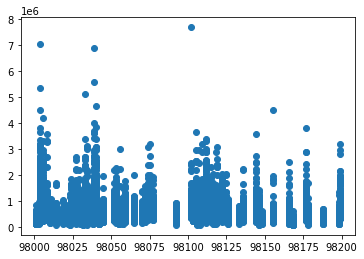

In [50]:
fig, ax = plt.subplots()
ax.scatter(df['zipcode'],df['price'])

If considering zip code, I think it should be considered as a categorical

### Model 7: zipcode included

#### Model 7a

Feel like zipcode should be considered a categorical. Its like the name of a neighborhood. Trying it as a value  first

In [189]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','zipcode','sqft_living'],
                 cat_col =['condition',]
                )

Categorical columns: ['condition'] 
Numerical Columns:  ['bedrooms', 'bathrooms', 'zipcode', 'sqft_living']
Training Score: 0.5157035560235042
Test Score: 0.5422394708010596

Training Metrics:
Mean Absolute Error: 167442.718
Mean Squared Error: 65511141715.620
Root Mean Squared Error: 255951.444

Testing Metrics:
Mean Absolute Error: 164688.392
Mean Squared Error: 59993786236.524
Root Mean Squared Error: 244936.290


#### Model 7b

In [190]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['zipcode','sqft_living'],
                 cat_col =['condition','bedrooms','bathrooms',]
                )

Categorical columns: ['condition', 'bedrooms', 'bathrooms'] 
Numerical Columns:  ['zipcode', 'sqft_living']
Training Score: 0.555546517724687
Test Score: 0.5219759518892777

Training Metrics:
Mean Absolute Error: 161919.741
Mean Squared Error: 60121554526.120
Root Mean Squared Error: 245196.971

Testing Metrics:
Mean Absolute Error: 161963.786
Mean Squared Error: 62649509359.093
Root Mean Squared Error: 250298.840


#### Model 7c

In [191]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['bedrooms','bathrooms','zipcode','condition']
                )

Categorical columns: ['bedrooms', 'bathrooms', 'zipcode', 'condition'] 
Numerical Columns:  ['sqft_living']
Training Score: 0.7603067968106887
Test Score: 0.7342411396853641

Training Metrics:
Mean Absolute Error: 105111.660
Mean Squared Error: 32423478631.134
Root Mean Squared Error: 180065.207

Testing Metrics:
Mean Absolute Error: 105435.194
Mean Squared Error: 34830177001.236
Root Mean Squared Error: 186628.446


PROMISING! 

$_{only~thing~so~far}$

#### Model 7d

In [192]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =['zipcode','condition']
                )

Categorical columns: ['zipcode', 'condition'] 
Numerical Columns:  ['bedrooms', 'bathrooms', 'sqft_living']
Training Score: 0.7386270059237772
Test Score: 0.7479030779337765

Training Metrics:
Mean Absolute Error: 110377.173
Mean Squared Error: 35356120137.843
Root Mean Squared Error: 188032.232

Testing Metrics:
Mean Absolute Error: 109376.272
Mean Squared Error: 33039652588.207
Root Mean Squared Error: 181768.129


Least RMSE yet

#### Model 7e

In [193]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','sqft_living'],
                 cat_col =['bathrooms','zipcode','condition']
                )

Categorical columns: ['bathrooms', 'zipcode', 'condition'] 
Numerical Columns:  ['bedrooms', 'sqft_living']
Training Score: 0.7591455233968127
Test Score: 0.7349127919723308

Training Metrics:
Mean Absolute Error: 105456.908
Mean Squared Error: 32580564953.227
Root Mean Squared Error: 180500.872

Testing Metrics:
Mean Absolute Error: 105359.372
Mean Squared Error: 34742150705.478
Root Mean Squared Error: 186392.464


#### Model 7f

In [194]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living'],
                 cat_col =['bedrooms','zipcode','condition']
                )

Categorical columns: ['bedrooms', 'zipcode', 'condition'] 
Numerical Columns:  ['bathrooms', 'sqft_living']
Training Score: 0.7389316462409866
Test Score: 0.747634892651345

Training Metrics:
Mean Absolute Error: 110389.795
Mean Squared Error: 35314911214.587
Root Mean Squared Error: 187922.620

Testing Metrics:
Mean Absolute Error: 109463.378
Mean Squared Error: 33074800770.454
Root Mean Squared Error: 181864.787


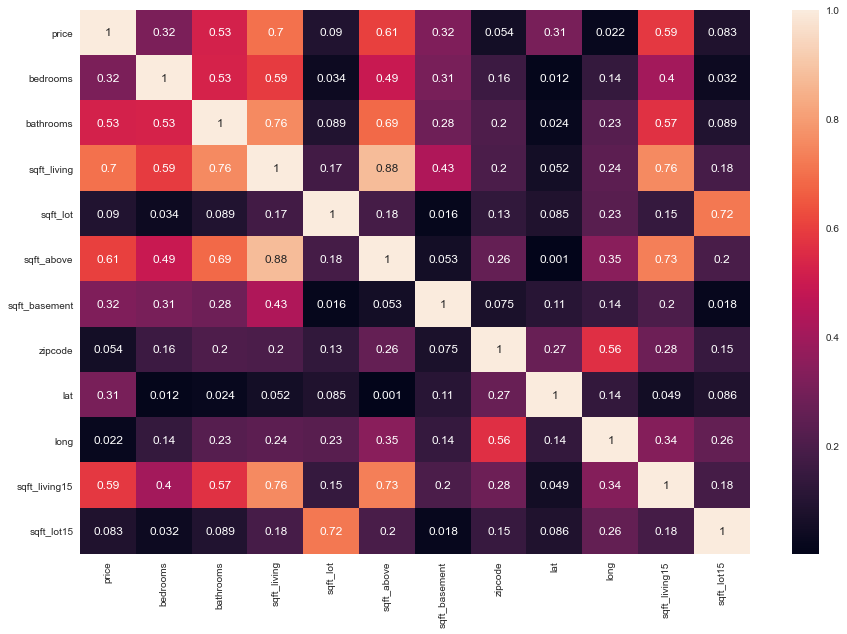

In [119]:
# sns.heatmap(df.corr(),annot=True)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(abs(df.corr()),annot=True)

#### Model 7g

In [195]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['bedrooms','bathrooms','zipcode','condition','view','waterfront']
                )

Categorical columns: ['bedrooms', 'bathrooms', 'zipcode', 'condition', 'view', 'waterfront'] 
Numerical Columns:  ['sqft_living']
Training Score: 0.8104751141599948
Test Score: 0.772462987714553

Training Metrics:
Mean Absolute Error: 96825.623
Mean Squared Error: 25637172870.722
Root Mean Squared Error: 160116.123

Testing Metrics:
Mean Absolute Error: 98385.723
Mean Squared Error: 29820847375.895
Root Mean Squared Error: 172687.137


## Deepdive in Model 7g

Get all the necessary variables (R^2, Condition No, p-values, coeffiencts, intercept)

### First a sanity check. Manual Run of methods

In [138]:
cols = ['sqft_living','bedrooms','bathrooms','zipcode','condition','view','waterfront']
cat_col =['bedrooms','bathrooms','zipcode','condition','view','waterfront']
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [201]:
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')
ct = ColumnTransformer(transformers=[('ohe', encoder, cat_col)],
                           remainder='passthrough')

#Fit Column Transformer
ct.fit(X_train_subset)

#Get your encoded Training and Test sets. Sometimes need to force todens(0) depending upon size of output
try:
    X_train_enc = ct.transform(X_train_subset).todense()
except:
    X_train_enc = ct.transform(X_train_subset)

try:
    X_test_enc = ct.transform(X_test_subset).todense()
except:
    X_test_enc = ct.transform(X_test_subset)


In [218]:
#Scale
scaler = RobustScaler()
scaler.fit(X_train_enc)
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [219]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds=lr.predict(X_train_scaled)
test_preds=lr.predict(X_test_scaled)

In [220]:
print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.8104751141599948
Test Score: 0.772462987714553


### OLS Summary

In [221]:
#Just to get summary
model = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_scaled)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     551.3
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:36:42   Log-Likelihood:            -2.0199e+05
No. Observations:               15071   AIC:                         4.042e+05
Df Residuals:                   14954   BIC:                         4.051e+05
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.874e+05   8.19e+04      3.511      0.000    1.27e+05    4.48e+05
x1         -1.629e+04   1.42e+04     -1.149      0.251   -4.41e+04    1.15e+04
x2          -2.18e+04   1.41e+04     -1.542      0.123   -4.95e+04    5912.754
x3         -4.964e+04   1.45e+04     -3.428      0.001    -7.8e+04   -2.13e+04
x4         -9.669e+04   1.53e+04     -6.331      0.000   -1.27e+05   -6.68e+04
x5         -1.984e+05   1.89e+04    -10.507      0.000   -2.35e+05   -1.61e+05
x6         -1.828e+05   3.62e+04     -5.052      0.000   -2.54e+05   -1.12e+05
x7         -2.423e+05    5.4e+04     -4.484      0.000   -3.48e+05   -1.36e+05
x8         -2.926e+05   7.44e+04     -3.934      0.000   -4.38e+05   -1.47e+05
x9         -7.325e+05   1.18e+05     -6.232      0.000   -9.63e+05   -5.02e+05
x10         3.325e+04   8.37e+04      0.397      0.691   -1.31e+05    1.97e+05
x11         5.142e+04   8.06e+04      0.638      0.524   -1.07e+05    2.09e+05
x12        -9.501e+04   1.04e+05     -0.914      0.361   -2.99e+05    1.09e+05
x13         2.261e+04   8.08e+04      0.280      0.780   -1.36e+05    1.81e+05
x14         7391.0647   8.07e+04      0.092      0.927   -1.51e+05    1.66e+05
x15         1.072e+04   8.07e+04      0.133      0.894   -1.48e+05    1.69e+05
x16         1.109e+04   8.07e+04      0.137      0.891   -1.47e+05    1.69e+05
x17         8671.8316   8.07e+04      0.107      0.914   -1.49e+05    1.67e+05
x18          321.6471   8.09e+04      0.004      0.997   -1.58e+05    1.59e+05
x19          2.89e+04    8.1e+04      0.357      0.721    -1.3e+05    1.88e+05
x20         8.093e+04   8.11e+04      0.998      0.318   -7.81e+04     2.4e+05
x21         5.259e+04   8.11e+04      0.649      0.517   -1.06e+05    2.11e+05
x22         1.419e+05   8.23e+04      1.725      0.085   -1.93e+04    3.03e+05
x23         1.706e+05   8.25e+04      2.069      0.039    8969.919    3.32e+05
x24         2.653e+05   8.42e+04      3.149      0.002       1e+05     4.3e+05
x25         1.803e+05   8.31e+04      2.169      0.030    1.73e+04    3.43e+05
x26          4.29e+05   9.01e+04      4.762      0.000    2.52e+05    6.06e+05
x27         4.496e+05   9.06e+04      4.961      0.000    2.72e+05    6.27e+05
x28         4.327e+05   9.52e+04      4.546      0.000    2.46e+05    6.19e+05
x29         1.044e+06   1.02e+05     10.258      0.000    8.45e+05    1.24e+06
x30         8.327e+05   1.24e+05      6.693      0.000    5.89e+05    1.08e+06
x31         4.812e+05   1.15e+05      4.171      0.000    2.55e+05    7.07e+05
x32         1.418e+06   1.81e+05      7.847      0.000    1.06e+06    1.77e+06
x33         2.658e+05    1.4e+05      1.896      0.058   -9000.863    5.41e+05
x34        -7.172e+05   1.84e+05     -3.900      0.000   -1.08e+06   -3.57e+05
x35        -3.081e+05   1.94e+05     -1.585      0.113   -6.89e+05     7.3e+04
x3

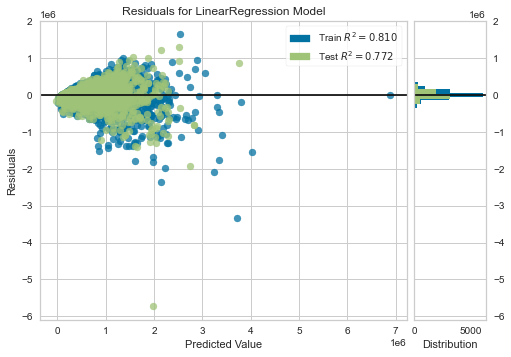

In [222]:
# visualizing our residuals 
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

In [223]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
train_residuals

10318    -27991.644593
13810    -44489.579134
7902     -45790.196362
14514     22787.678348
911       41815.345297
             ...      
11325     80554.818807
12008     59209.384511
5410      41191.451383
866     -248120.295681
15850     17518.602965
Name: price, Length: 15071, dtype: float64

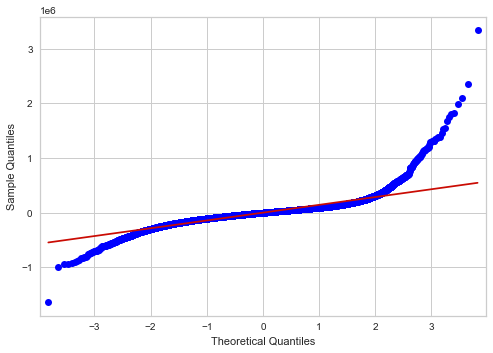

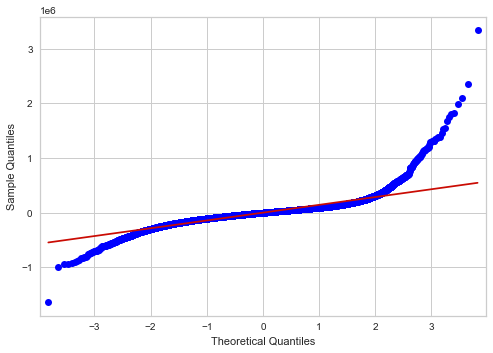

In [208]:
sm.qqplot(train_residuals, line = 'r')

Makes intuitive sense. Intercept around 540k. Houses around King County are expensive: mean 540k, median: 450k

Some zip codes have a much higher impact on prices. pricier neighborhoods

## LOG (Price)

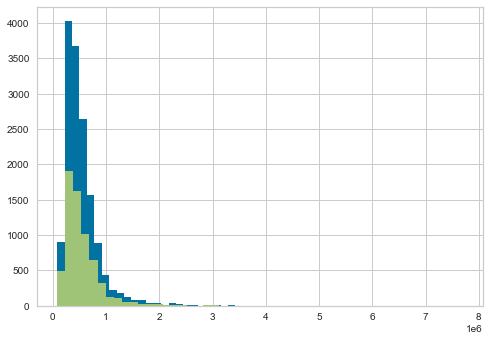

In [236]:
plt.hist(y_train,bins = 50)
plt.hist(y_test,bins = 50);

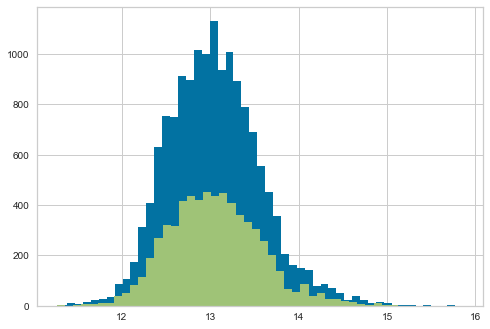

In [237]:
plt.hist(np.log(y_train),bins = 50)
plt.hist(np.log(y_test),bins = 50);

In [226]:
#USE encoded training and test  sets here!
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

pipe_log = make_pipeline(RobustScaler(), LinearRegression())
pipe_log.fit(X_train_enc, log_y_train) 
print("Training Score:",pipe_log.score(X_train_enc, log_y_train))
print("Test Score:",pipe_log.score(X_test_enc, log_y_test))

Training Score: 0.8533174909222758
Test Score: 0.8541294186063142


In [227]:
#Just to get summary
model = sm.OLS(endog=log_y_train, exog=sm.add_constant(X_train_scaled)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     749.9
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:39:08   Log-Likelihood:                 2747.6
No. Observations:               15071   AIC:                            -5261.
Df Residuals:                   14954   BIC:                            -4370.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1167      0.103    117.534      0.000      11.915      12.319
x1             0.0362      0.018      2.025      0.043       0.001       0.071
x2             0.0553      0.018      3.109      0.002       0.020       0.090
x3             0.0479      0.018      2.625      0.009       0.012       0.084
x4            -0.0226      0.019     -1.175      0.240      -0.060       0.015
x5            -0.1081      0.024     -4.543      0.000      -0.155      -0.061
x6            -0.1442      0.046     -3.164      0.002      -0.234      -0.055
x7            -0.2591      0.068     -3.808      0.000      -0.392      -0.126
x8            -0.1968      0.094     -2.101      0.036      -0.380      -0.013
x9            -0.4617      0.148     -3.119      0.002      -0.752      -0.172
x10            0.2051      0.105      1.947      0.052      -0.001       0.412
x11            0.2556      0.102      2.518      0.012       0.057       0.455
x12            0.1318      0.131      1.007      0.314      -0.125       0.388
x13            0.2815      0.102      2.767      0.006       0.082       0.481
x14            0.3051      0.102      3.002      0.003       0.106       0.504
x15            0.3031      0.102      2.981      0.003       0.104       0.502
x16            0.3311      0.102      3.256      0.001       0.132       0.530
x17            0.3533      0.102      3.476      0.001       0.154       0.552
x18            0.3511      0.102      3.447      0.001       0.151       0.551
x19            0.3471      0.102      3.404      0.001       0.147       0.547
x20            0.3691      0.102      3.613      0.000       0.169       0.569
x21            0.3643      0.102      3.568      0.000       0.164       0.564
x22            0.3946      0.104      3.809      0.000       0.192       0.598
x23            0.3685      0.104      3.548      0.000       0.165       0.572
x24            0.3216      0.106      3.031      0.002       0.114       0.530
x25            0.2910      0.105      2.779      0.005       0.086       0.496
x26            0.2952      0.113      2.603      0.009       0.073       0.518
x27            0.3377      0.114      2.959      0.003       0.114       0.561
x28            0.2981      0.120      2.487      0.013       0.063       0.533
x29            0.2714      0.128      2.117      0.034       0.020       0.523
x30           -0.1757      0.157     -1.121      0.262      -0.483       0.131
x31            0.1082      0.145      0.744      0.457      -0.177       0.393
x32            0.3259      0.228      1.432      0.152      -0.120       0.772
x33            0.1515      0.177      0.858      0.391      -0.195       0.498
x34           -0.5549      0.232     -2.396      0.017      -1.009      -0.101
x35           -0.2087      0.245     -0.852      0.394      -0.689       0.271
x3

In [228]:
train_residuals = log_y_train - pipe_log.predict(X_train_enc)
test_residuals = log_y_test - pipe_log.predict(X_test_enc)

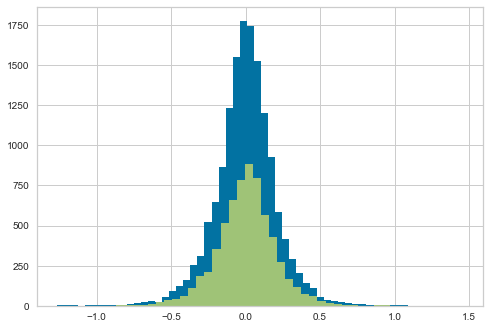

In [229]:
plt.hist(train_residuals,bins = 50);
plt.hist(test_residuals,bins = 50);

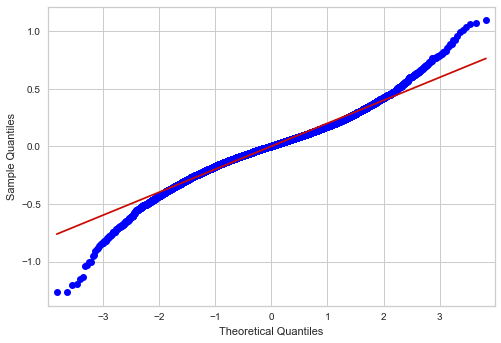

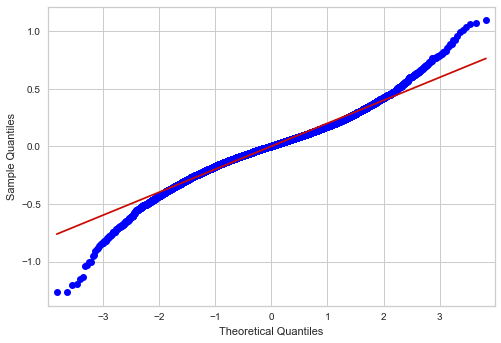

In [230]:
sm.qqplot(train_residuals, line = 'r')

## BOX COX (Price)

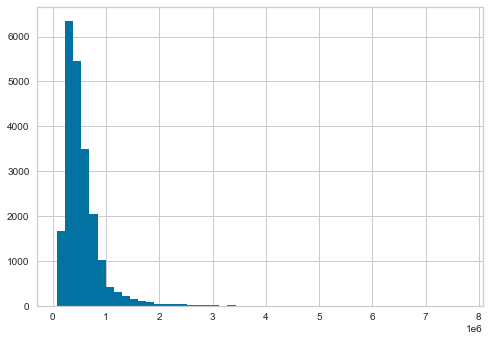

In [231]:
plt.hist(df.price,bins = 50);

In [234]:
power_transform(df.price)

ValueError: Expected 2D array, got 1D array instead:
array=[221900. 538000. 180000. ... 402101. 400000. 325000.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [214]:
test = [[ 1., -2.,  2.],[ -2.,  1.,  3.],[ 4.,  1., -2.]]

In [216]:
ss = StandardScaler()
ss.fit_transform(test)

array([[ 0.        , -1.41421356,  0.46291005],
       [-1.22474487,  0.70710678,  0.9258201 ],
       [ 1.22474487,  0.70710678, -1.38873015]])

In [217]:
rs = RobustScaler()
rs.fit_transform(test)

array([[ 0. , -2. ,  0. ],
       [-1. ,  0. ,  0.4],
       [ 1. ,  0. , -1.6]])

## Some weird plots

In [111]:
df_pairplotting1 = df.filter(['bedrooms','bathrooms','floors','view','condition','price'])
df_pairplotting2 = df.filter(['bedrooms','sqft_living', 'sqft_lot','sqft_above','sqft_living15', 'sqft_lot15','price'])

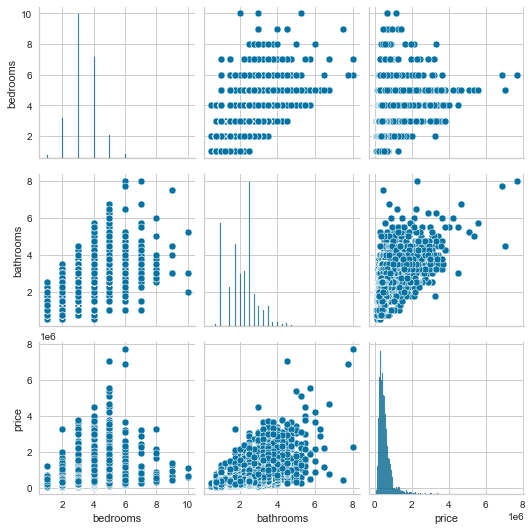

In [112]:
sns.pairplot(df_pairplotting1)

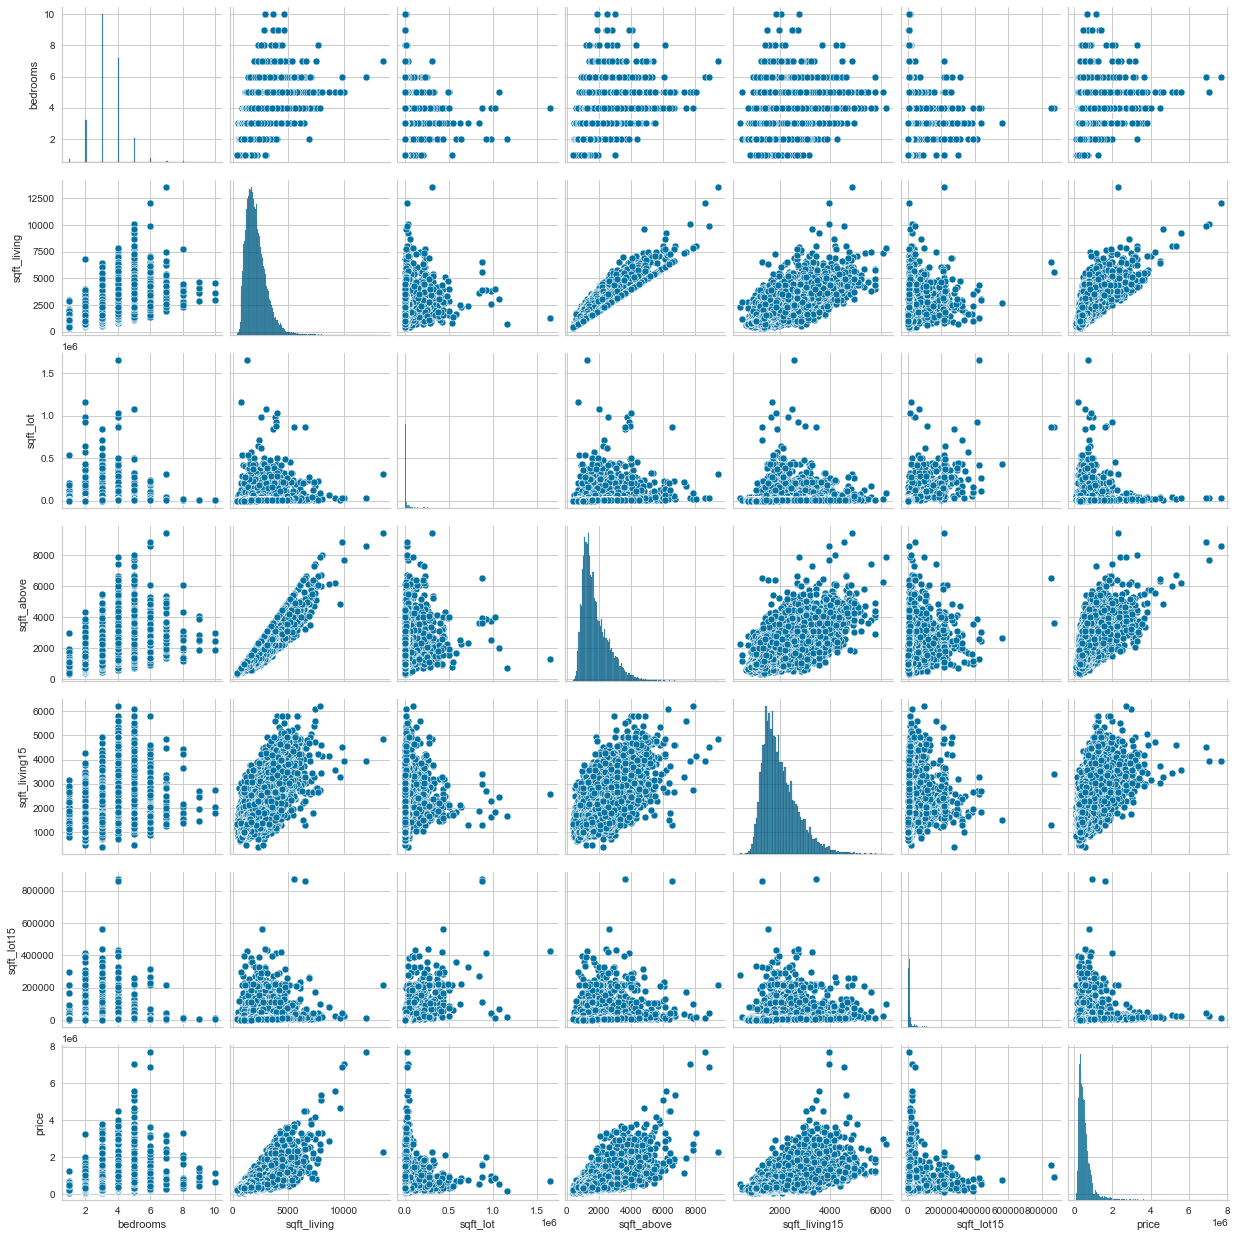

In [113]:
sns.pairplot(df_pairplotting2)